## Double-Well SDE and PriorVAE

In [2]:
import random as rnd

import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import optax
import flax.linen as nn

from priorCVAE.priors import DoubleWellSDE
from priorCVAE.datasets import SDEDataset
from priorCVAE.models import MLPDecoder, MLPEncoder, VAE, MLPDecoderTwoHeads
from priorCVAE.trainer import VAETrainer
from priorCVAE.utility import save_model_params
from priorCVAE.losses import SquaredSumAndKL, NLLAndKL

## Configuration

In [3]:
args = {
        # setup
        "t0" : 0,
        "t1" : 20,
        "dt" : 0.01,
        
        # architecture
        "input_dim" : None,  # This is set later depending on the time-grid
        "decoder_twoheads": False,
        "hidden_dim": [1000, 500, 100],
        "activation_fn": nn.sigmoid,
        "latent_dim": 50,
        
        # VAE training    
        "batch_size": 2000,
        "num_iterations": 4000,
        "learning_rate": 1e-3,
        "vae_var": 0.1
       }

## Simulate the SDE and generate data

In [4]:
base_sde = DoubleWellSDE(c=2, q=3)
x_init = jnp.ones((1, 1))

sde_dataset_generator = SDEDataset(base_sde, x_init, dt=args["dt"], t_lim_high=args["t1"], t_lim_low=args["t0"]) 

In [5]:
sample_t_train, sample_y_train, _ = sde_dataset_generator.simulatedata(n_samples=100)
t_test, y_test, _ = sde_dataset_generator.simulatedata(n_samples=100)

In [6]:
args["input_dim"] = sample_y_train.shape[1]

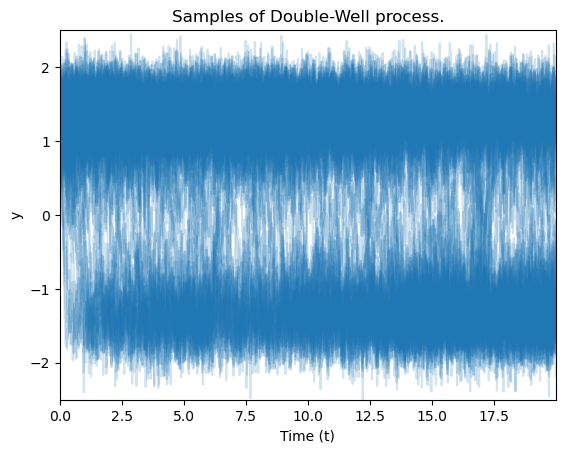

In [7]:
for y_i in sample_y_train:
    plt.plot(sample_t_train[0], y_i, color="tab:blue", alpha=0.2)

plt.xlim([sample_t_train[0][0], sample_t_train[0][-1]])
plt.ylim([-2.5, 2.5])
plt.title("Samples of Double-Well process.")
plt.xlabel("Time (t)")
plt.ylabel("y")
plt.show()

## PriorVAE model

In [8]:
out_dim     = args["input_dim"]
hidden_dim  = args["hidden_dim"]
latent_dim  = args["latent_dim"]
batch_size  = args["batch_size"]
num_iterations  = args["num_iterations"]
learning_rate = args["learning_rate"]
vae_var = args["vae_var"]
decoder_twoheads = args["decoder_twoheads"]
activation_fn = args["activation_fn"]

decoder_hidden_list = hidden_dim
decoder_hidden_list.reverse()

In [9]:
encoder = MLPEncoder(hidden_dim, latent_dim, activation_fn)

if decoder_twoheads:
    decoder = MLPDecoderTwoHeads(decoder_hidden_list, out_dim, activation_fn)
else:
    decoder = MLPDecoder(decoder_hidden_list, out_dim, activation_fn)
model = VAE(encoder, decoder)

optimizer = optax.adam(learning_rate=learning_rate)

## Train the model

In [10]:
if decoder_twoheads:
    loss = NLLAndKL()
else:
    loss = SquaredSumAndKL(vae_var=vae_var)

trainer = VAETrainer(model, optimizer, loss=loss)
trainer.init_params(sample_y_train[0])

test_set = (t_test, y_test, _)
loss_vals, test_vals, time_taken = trainer.train(sde_dataset_generator, test_set, num_iterations)

print(f'Training of {num_iterations} iterations took {round(time_taken)} seconds')


[    1] training loss: 1986908.125, test loss: 1693123.625
[   11] training loss: 1546326.375, test loss: 1567839.125
[   21] training loss: 1613563.250, test loss: 1528143.500
[   31] training loss: 1463959.750, test loss: 1432447.250
[   41] training loss: 1309445.375, test loss: 1325655.750
[   51] training loss: 1315034.500, test loss: 1275555.500
[   61] training loss: 1178380.500, test loss: 1208488.750
[   71] training loss: 1145725.375, test loss: 1130439.750
[   81] training loss: 1080653.375, test loss: 1082901.875
[   91] training loss: 1062082.250, test loss: 1050063.125
[  101] training loss: 1001062.500, test loss: 1030478.938
[  111] training loss: 1053616.625, test loss: 1045717.125
[  121] training loss: 1140398.875, test loss: 1025570.125
[  131] training loss: 1035015.188, test loss: 1026529.688
[  141] training loss: 994194.625, test loss: 1022160.688
[  151] training loss: 962650.812, test loss: 1026032.062
[  161] training loss: 985178.375, test loss: 1027900.125


[ 1441] training loss: 315694.438, test loss: 342330.438
[ 1451] training loss: 324143.188, test loss: 349043.406
[ 1461] training loss: 293165.219, test loss: 344622.906
[ 1471] training loss: 342488.781, test loss: 345685.875
[ 1481] training loss: 326375.312, test loss: 346321.156
[ 1491] training loss: 345366.344, test loss: 347081.562
[ 1501] training loss: 384670.656, test loss: 352081.562
[ 1511] training loss: 353315.906, test loss: 343954.844
[ 1521] training loss: 320108.531, test loss: 343204.562
[ 1531] training loss: 328278.438, test loss: 341221.250
[ 1541] training loss: 326025.688, test loss: 336998.438
[ 1551] training loss: 308036.312, test loss: 340408.781
[ 1561] training loss: 317296.219, test loss: 339551.438
[ 1571] training loss: 334929.438, test loss: 339591.125
[ 1581] training loss: 337383.344, test loss: 338725.875
[ 1591] training loss: 342344.719, test loss: 338471.844
[ 1601] training loss: 362573.875, test loss: 339993.844
[ 1611] training loss: 325207.7

[ 2881] training loss: 276491.219, test loss: 269519.438
[ 2891] training loss: 262216.312, test loss: 269165.625
[ 2901] training loss: 277902.031, test loss: 267718.844
[ 2911] training loss: 283776.125, test loss: 270452.656
[ 2921] training loss: 251964.391, test loss: 268617.750
[ 2931] training loss: 296664.125, test loss: 269358.219
[ 2941] training loss: 246117.234, test loss: 271388.531
[ 2951] training loss: 258933.703, test loss: 268380.281
[ 2961] training loss: 268905.125, test loss: 268735.125
[ 2971] training loss: 252037.875, test loss: 266138.094
[ 2981] training loss: 253149.031, test loss: 269230.125
[ 2991] training loss: 253896.938, test loss: 265993.938
[ 3001] training loss: 274628.531, test loss: 261803.953
[ 3011] training loss: 278477.531, test loss: 263746.688
[ 3021] training loss: 274656.969, test loss: 263395.781
[ 3031] training loss: 253264.688, test loss: 266255.594
[ 3041] training loss: 265193.188, test loss: 268517.281
[ 3051] training loss: 250774.3

Text(0.5, 1.0, 'Test loss')

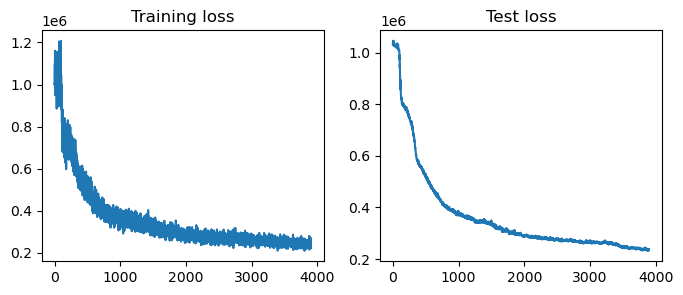

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

skip_initial = 100

axs[0].plot(range(len(loss_vals) - skip_initial), loss_vals[skip_initial:])
axs[0].set_title('Training loss')

axs[1].plot(range(len(test_vals) - skip_initial), test_vals[skip_initial:])
axs[1].set_title("Test loss")


## Samples from trained decoder

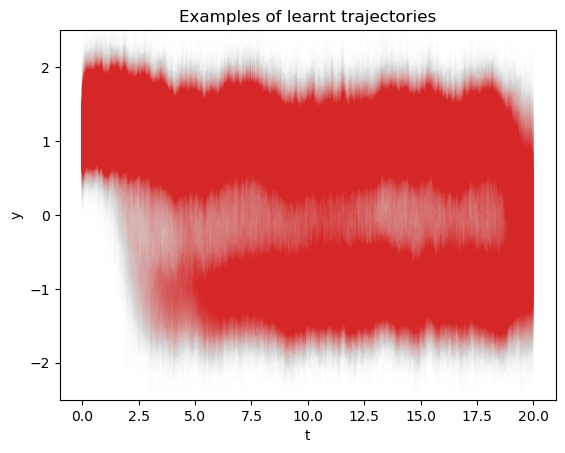

In [14]:
decoder_params = trainer.state.params['decoder']

key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = jax.random.split(key, 3)
z = jax.random.normal(z_rng, (batch_size, latent_dim))

if decoder_twoheads:
    decoder = MLPDecoderTwoHeads(hidden_dim, out_dim, activation_fn)
    out_m, out_log_S = decoder.apply({'params': decoder_params}, z)      
else:
    decoder = MLPDecoder(hidden_dim, out_dim, activation_fn)
    out_m = decoder.apply({'params': decoder_params}, z) 
    out_log_S = jnp.log(vae_var * jnp.ones_like(out_m))

# sampling
out_std = jnp.exp(0.5 * out_log_S)
eps = jax.random.normal(rng, out_std.shape)
out = out_m + eps * out_std

for i in range(1000):
    plt.plot(sample_t_train[0], out[i,:], color="tab:red", alpha=0.005)

plt.xlabel('t')
plt.ylabel('y')
plt.ylim([-2.5, 2.5])
plt.title('Examples of learnt trajectories')

plt.show()

In [15]:
## Generate 1000 samples
key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = jax.random.split(key, 3)
z = jax.random.normal(z_rng, (2000, latent_dim))

if decoder_twoheads:
    decoder = MLPDecoderTwoHeads(hidden_dim, out_dim, activation_fn)
    out_m, out_log_S = decoder.apply({'params': decoder_params}, z)      
    # sampling
    out_std = jnp.exp(0.5 * out_log_S)
    eps = jax.random.normal(rng, out_std.shape)
    out = out_m + eps * out_std
else:
    decoder = MLPDecoder(hidden_dim, out_dim, activation_fn)
    out = decoder.apply({'params': decoder_params}, z)    

In [16]:
out.shape

(2000, 2000)

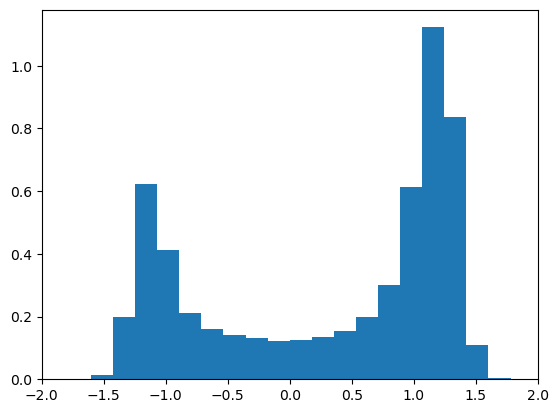

In [17]:
plt.hist(out.reshape(-1), bins=20, density=True)
plt.xlim([-2, 2])
plt.show()

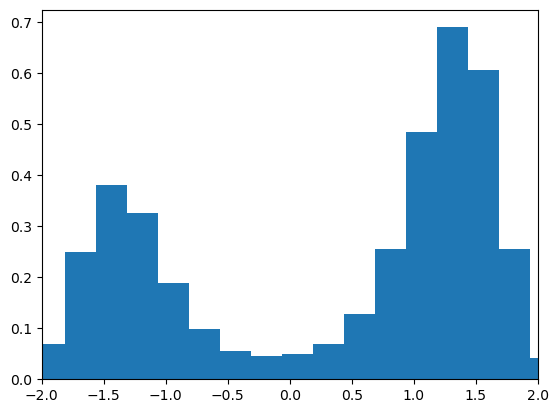

In [18]:
plt.hist(sample_y_train.reshape(-1), bins=20, density=True)
plt.xlim([-2, 2])
plt.show()

In [ ]:
# save_model_params("DW/16000_3_hidden", trainer.state.params)